In [1]:
# pip install ipympl matplotlib
%matplotlib widget
import socket
import uuid
import struct
import pickle
import rsa
import datetime
import time
from base64 import b64decode, b64encode

DAEMON_COMMANDS = {
    # script control commands
    'start':          0x01,
    'simulate':       0x02,
    'queue':          0x03,
    'unqueue':        0x04,
    'update':         0x05,
    # script flow commands
    'break':          0x11,
    'continue':       0x12,
    'stop':           0x13,
    'emergency':      0x14,
    'finish':         0x15,
    # async execution commands
    'exec':           0x21,
    'eval':           0x22,
    # watch variable commands
    'watch':          0x31,
    'unwatch':        0x32,
    # enquiries
    'getversion':     0x41,
    'getstatus':      0x42,
    'getmessages':    0x43,
    'getscript':      0x44,
    'gethistory':     0x45,
    'getcachekeys':   0x46,
    'gettrace':       0x47,
    'getdataset':     0x48,
    # miscellaneous commands
    'complete':       0x51,
    'transfer':       0x52,
    'debug':          0x53,
    'debuginput':     0x54,
    # connection related commands
    'eventmask':      0x61,
    'unlock':         0x62,
    'quit':           0x63,
    'authenticate':   0x64,  # only used during handshake
    'eventunmask':    0x65,
    'rearrange':      0x66,
    'keepalive':      0x67,
}

HOST = "localhost"
PORT = 3389

ENQ = b'\x05'
LENGTH = struct.Struct('>I')
READ_BUFSIZE = 4096

In [2]:
class Client:
    def __init__(self):
        self._socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self._socket.connect((HOST, PORT))
        self._socket.setsockopt(socket.SOL_SOCKET, socket.SO_KEEPALIVE, 1)
        self.rsakey = None

    def connect(self):
        client_id = uuid.uuid1().bytes
        self._socket.sendall(client_id)
        buf = self.recv_reply()
        banner = pickle.loads(buf, encoding='latin1')
        self.rsakey = banner.get('rsakey', None)
        return banner
        
    def recv_reply(self):
        # receive first byte + (possibly) length
        start = b''
        while len(start) < 5:
            data = self._socket.recv(5 - len(start))
            start += data
        # it has a length...
        length, = LENGTH.unpack(start[1:])
        buf = b''
        while len(buf) < length:
            read = self._socket.recv(READ_BUFSIZE)
            buf += read
        return buf
    
    def ask(self, command, *args, **kwargs):
        command = DAEMON_COMMANDS.get(command, None)
        if command:
            cmd = struct.Struct('>H').pack(command)
        else:
            raise RuntimeError("Unrecognised command")
        a = pickle.dumps(args, 2)
        self._socket.sendall(ENQ + cmd + LENGTH.pack(len(a)) + a)
        data = self.recv_reply()
        return pickle.loads(data, encoding='latin1')

    def tell(self, command, *args):
        result = self.ask(command, *args)
        print(self.ask('getmessages'))
        print(result)
        print("done")
    
    def eval(self, statement):
        return self.ask('eval', statement, False, quiet=True, default=Ellipsis)

    def run(self, code):
        req_id = self.ask('start', '', code)
        return req_id        

    def login(self, user, password):
        pubkey = rsa.PublicKey.load_pkcs1(b64decode(self.rsakey))
        password = rsa.encrypt(password.encode(), pubkey)
        password = 'RSA:' + b64encode(password).decode()
        credentials = {
            'login': user,
            'passwd': password,
            'display': '',
        }
        return self.ask('authenticate', credentials)

In [3]:
client = Client()
banner = client.connect()
print(banner)
response = client.login("guest", "")
print(response)

{'daemon_version': '3.8.8.post2154+gd5ed6', 'custom_version': '3.8.8.post2154+gd5ed6', 'nicos_root': '/ess/ecdc/nicos-core', 'custom_path': '/ess/ecdc/nicos-core/nicos_ess', 'pw_hashing': 'rsa,plain', 'rsakey': b'LS0tLS1CRUdJTiBSU0EgUFVCTElDIEtFWS0tLS0tCk1FZ0NRUUNTYjVNUS9iSXlMMjhsSk5YeVpXWGpRWkoyZDZuUVo1a3R1bW1WTmFhWENyditGbWVYVjd1UnRpTkwKakFwb0ZkQnRlYUNuSlM4SldRS2RIV2VjZGFBVkFnTUJBQUU9Ci0tLS0tRU5EIFJTQSBQVUJMSUMgS0VZLS0tLS0K', 'protocol_version': 23, 'serializer': 'classic'}
{'user_level': 0}


In [4]:
response = client.eval("mY.read()")
print(response)

name 'mY' is not defined


In [5]:
def get_history(device, start, end, interval=2.0):
    raw = client.ask('gethistory', device, start, end, 2.0)
    t = [datetime.datetime.fromtimestamp(x) for (x, _) in raw]
    v = [y for (_, y) in raw]
    return (t, v)

import time
my_history = get_history('camera_box_motor/value', 1690878499.473055, time.time())


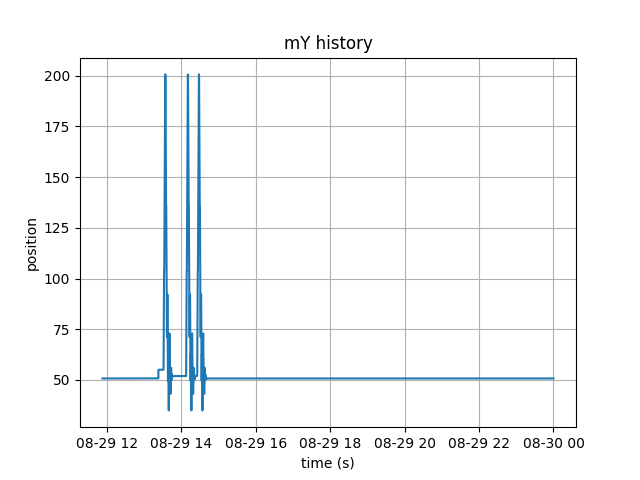

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(*my_history)

ax.set(xlabel='time (s)', ylabel='position',
       title='mY history')
ax.grid()

plt.show()

In [7]:
client.run("mY.move(40)")

'3631d5fa-3520-11ee-9b8a-fa163e943f63'

In [8]:
client.run("mY.read()")

'36f812ec-3520-11ee-9b8a-fa163e943f63'

In [9]:
client.ask("getcachekeys", 'my/value')

[('my/value', 40.0)]

In [10]:
client.ask("getscript")

'mY.read()'

In [12]:
# dry run example
script = """
print("script")
"""

client.tell("simulate", '', script, 0)

KeyboardInterrupt: 

In [4]:
client.run("maw(mY, 50)")

'eb79e910-3508-11ee-9554-fa163e943f63'